# Intro

This notebook is measurement report on the NLNet018TV test chip. I gives the procedures for measurements and the results. Deeper discussion of the results will be done in a separate notebook.

# Setup

In [1]:
from importlib import reload
import sys
from time import time, sleep

import numpy as np
from matplotlib import pyplot as plt

# Reload already loaded modules
for m in ("AD5522_pi", "AD7685_pi", "AD5522dev_pi"):
    try:
        mod = sys.modules[m]
    except KeyError:
        pass
    else:
        reload(mod)
from AD5522dev_pi import AD5522dev
from AD5522_pi import MeasMode

Provide three measurement channels and one 1.8V channel. The 3.3V is delivered directly from the Raspberry Pi so we are not limited by the 22mA drive current through the SMU.

In [382]:
board = AD5522dev(vref=5.0)

green_channel = 0
green_ch = board.channels[green_channel]
green_ch.mode = MeasMode.HVMV

yellow_channel = 1
yellow_ch = board.channels[yellow_channel]
yellow_ch.mode = MeasMode.HVMV

blue_channel = 3
blue_ch = board.channels[blue_channel]
blue_ch.mode = MeasMode.HVMV

vdd18_channel = 2
vdd18_ch = board.channels[vdd18_channel]
vdd18_ch.mode = MeasMode.FVMI
vdd18_ch.force = 1.8

# Helpers

## Load data

Try to load data from disk, start fresh if that fails

In [356]:
try:
    # Load data from disk to extend it
    data = np.load("NLNet018TV.npz")["data"][()]
except:
    # Start anew
    data = {}

## Save

In [485]:
np.savez("NLNet018TV", data=data)
print("Data saved")

Data saved


## Meas Power on 1.8V

It is assumed that force on VDD18 is set to 1.8V and don't change it.

In [134]:
def meas_pow18():
    board.measchannel = vdd18_channel
    vdd18_ch.mode = MeasMode.FVMV
    v = board.measure(count=1000)[0]
    vdd18_ch.mode = MeasMode.FVMI
    i = 1000*board.measure(count=1000)[0]
    print("1.8V: {:.3f}V, {:.3f}mA, {:.3f}mW".format(v, i, v*i))
# meas_pow18()

## Meas voltage on green, yellow and blue channel

As side effect this measurement will put the three channel in HVMV mode.

In [135]:
def meas_vchannels():
    for name, channel, ch in (
        ("green", green_channel, green_ch),
        ("yellow", yellow_channel, yellow_ch),
        ("blue", blue_channel, blue_ch),
    ):
        ch.mode = MeasMode.HVMV
        board.measchannel = channel
        meas = board.measure(count=1000)
        print("{}: {}{}".format(name, meas[0], meas[1]))
# meas_vchannels()

# Board Bring-up

## Supply ramp-up

For this we connect VDD33 to blue channel and VDD18 to vdd18 channel.

### VDD18 ramp

#### VDD33 = 0V

Blue channel is used to put VDD33 to 0V

In [362]:
def _block():
    measdata = data.get("bringup", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.FVMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=0V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = 3.3V

Blue channel is used to put VDD33 to 3.3V

In [363]:
def _block():
    measdata = data.get("bringup", {})

    blue_ch.mode = MeasMode.FVMV
    blue_ch.force = 3.3
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.HVMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=3.3V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = 0A

Blue channel is put to zero current

In [364]:
def _block():
    measdata = data.get("bringup", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.FIMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FIMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FIMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=0A)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = HighV

Blue channel is put in High-V mode

In [365]:
def _block():
    measdata = data.get("bringup", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.HVMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.HVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.HVMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=High-V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = HighI

Blue channel is put in High-I mode

In [366]:
def _block():
    measdata = data.get("bringup", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.HIMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=High-I)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

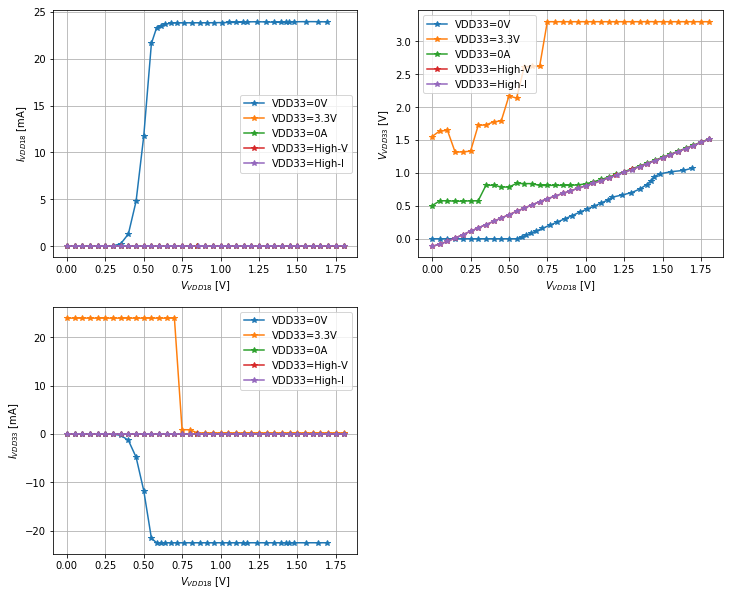

In [377]:
def _block():
    d_0V = data["bringup"]["VDD18 (VDD33=0V)"]
    d_33V = data["bringup"]["VDD18 (VDD33=3.3V)"]
    d_0A = data["bringup"]["VDD18 (VDD33=0A)"]
    d_HiV = data["bringup"]["VDD18 (VDD33=High-V)"]
    d_HiA = data["bringup"]["VDD18 (VDD33=High-I)"]
    ds = (d_0V, d_33V, d_0A, d_HiV, d_HiA)
    lgnd = ("VDD33=0V", "VDD33=3.3V", "VDD33=0A", "VDD33=High-V", "VDD33=High-I")
    
    plt.figure(figsize=(12,10))

    plt.subplot(2, 2, 1)
    for d in ds:
        plt.plot(d[:, 0], 1e3*d[: , 1], '*-')
    plt.legend(lgnd, loc="center right")
    plt.xlabel("$V_{VDD18}$ [V]")
    plt.ylabel("$I_{VDD18}$ [mA]")
    plt.grid("on")

    plt.subplot(2, 2, 2)
    for d in ds:
        plt.plot(d[:, 0], d[: , 2], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD18}$ [V]")
    plt.ylabel("$V_{VDD33}$ [V]")
    plt.grid("on")

    plt.subplot(2, 2, 3)
    for d in ds:
        plt.plot(d[:, 0], 1e3*d[: , 3], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD18}$ [V]")
    plt.ylabel("$I_{VDD33}$ [mA]")
    plt.grid("on")

    plt.show()
_block()

* Current on 1.8V supply is small when 3.3V is floating during ramp

### VDD33 ramp

#### VDD18=0V
* Keep VDD18 to 0V as it otherwise will clamp on maximum current
* Connect blue channel to VDD33

In [368]:
def _block():
    measdata = data.get("bringup", {})
    
    vdd18_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 0
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=0V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD18=1.8V
* Set voltage on VDD18 to 1.8V, will measure clamped voltage
* Connect blue channel to VDD33

In [369]:
def _block():
    measdata = data.get("bringup", {})
    
    vdd18_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 1.8
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=1.8V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD18=High-V
* Set VDD18 to High-V
* Connect blue channel to VDD33

In [370]:
def _block():
    measdata = data.get("bringup", {})
    
    vdd18_ch.mode = MeasMode.HVMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 0
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.HVMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.HVMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=High-V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD18=High-I
* Set VDD18 to High-I
* Connect blue channel to VDD33

In [371]:
def _block():
    measdata = data.get("bringup", {})
    
    vdd18_ch.mode = MeasMode.HIMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 0
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=High-I)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### Plot results

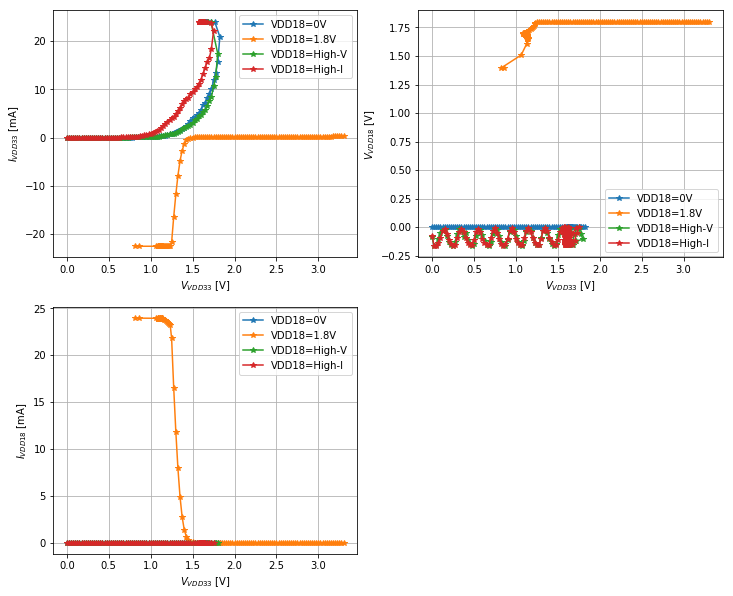

In [378]:
def _block():
    d_0V = data["bringup"]["VDD33 (VDD18=0V)"]
    d_1V8 = data["bringup"]["VDD33 (VDD18=1.8V)"]
    d_HiV = data["bringup"]["VDD33 (VDD18=High-V)"]
    d_HiA = data["bringup"]["VDD33 (VDD18=High-I)"]
    ds = (d_0V, d_1V8, d_HiV, d_HiA)
    lgnd = ("VDD18=0V", "VDD18=1.8V", "VDD18=High-V", "VDD18=High-I")
    
    plt.figure(figsize=(12,10))

    plt.subplot(2, 2, 1)
    for d in ds:
        plt.plot(d[:, 2], 1e3*d[: , 3], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD33}$ [V]")
    plt.ylabel("$I_{VDD33}$ [mA]")
    plt.grid("on")

    plt.subplot(2, 2, 2)
    for d in ds:
        plt.plot(d[:, 2], d[: , 0], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD33}$ [V]")
    plt.ylabel("$V_{VDD18}$ [V]")
    plt.grid("on")

    plt.subplot(2, 2, 3)
    for d in ds:
        plt.plot(d[:, 2], 1e3*d[: , 1], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD33}$ [V]")
    plt.ylabel("$I_{VDD18}$ [mA]")
    plt.grid("on")

    plt.show()
_block()

* Current flowing when VDD33 < 1.5V

# Measurements

# IO Test

## Default output values

* Different configurations on PUn/PD signals (pin 50-59)
* Measure voltage on TestIOn (pin 68-78)

| Input     | Pin | conf1 | conf2 | conf3 |
|-----------|-----|-------|-------|-------|
| PUSHAREDn | 50  | float | 1.8V  | 1.8V  |
| PUHIn     | 51  | float | 1.8V  | 1.8V  |
| PU2n      | 52  | float | 1.8V  | 1.8V  |
| PU1n      | 53  | float | 1.8V  | 1.8V  |
| PU0n      | 54  | float | 0V    | 1.8V  |
| PDSHARED  | 55  | float | 0V    | 0V    |
| PDHI      | 56  | float | 0V    | 0V    |
| PD2       | 57  | float | 0V    | 0V    |
| PD1       | 58  | float | 0V    | 0V    |
| PD0       | 59  | float | 0V    | 1.8V  |

| Output       | Pin | conf1   | conf2   | conf3   |
|--------------|-----|---------|---------|---------|
| TestIO1      | 68  | 3.054V  | 3.305V  | 0.044V  |
| TestIO2      | 69  | 3.031V  | 0.005V  | 0.044V  |
| TestIO3      | 70  | 2.999V  | 3.309V  | 2.868V  |
| TestIO4      | 71  | 0.195V  | 0.001V  | 2.168V  |
| TestIO4.CORE | 72  | 0.026V  | -0.000V | 1.799V  |
| TestIO5      | 73  | 3.057V  | 3.192V  | 2.865V  |
| TestIO6      | 74  | 3.056V  | 3.304V  | 0.045V  |
| TestIO7      | 75  | 3.059V  | 3.309V  | 0.045V  |
| TestIO8      | 76  | 3.056V  | 3.309V  | 0.045V  |
| TestIO9      | 77  | 3.058V  | 3.305V  | 0.045V  |
| TestIO10     | 78  | 3.038V  | 0.005V  | 2.864V  |
| VDD33        | *   | 133.3mA | 0.2mA   | 181,8mA |

* conf1 and conf3 seem to end up in IO cells where both a source and sink driver are enabled at the same time leading to high current going from VDD33 to GND
* conf2 is a state where no static current is present and thus good start for further testing.

## Drive currents
### PU0, PD1, PD2

* conf1 for input configuration
* green channel: TestIO1 (pin 68)
* yellow channel: TestIO2 (pin 69)
* blue channel: TestIO3 (pin 70)

In [195]:
def _block():
    measdata = data.get("iodrive", {})
    def _setandmeasure(ch, vset):
        meas = []
        ch.force = vset
        
        ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        return meas

    vs = np.arange(0, 3.301, 0.075)
    
    # PU0 current
    board.measchannel = green_channel
    measdata["pu0"] = np.array(tuple(_setandmeasure(green_ch, v) for v in vs))

    # PD1 current (PU0 is also on)
    green_ch.mode = MeasMode.FVMV
    green_ch.force = 3.3 # Enable PD1 on TestIO1
    board.measchannel = yellow_channel
    measdata["pd1"] = np.array(tuple(_setandmeasure(yellow_ch, v) for v in vs))
    
    # PD2 current (PU0 is also on)
    green_ch.mode = MeasMode.FVMV
    green_ch.force = 0.0 # Disable PD1 on TestIO1
    yellow_ch.mode = MeasMode.FVMV
    yellow_ch.force = 3.3 # Enable PD2 on TestIO2
    board.measchannel = blue_channel
    measdata["pd2"] = np.array(tuple(_setandmeasure(blue_ch, v) for v in vs))

    data["iodrive"] = measdata

    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

### PDHi

* conf1 for input configuration
* green channel: TestIO3 (pin 70)
* yellow channel: TestIO4 (pin 71)
* blue channel: TestIO4.CORE (pin 72)

In [200]:
def _block():
    measdata = data.get("iodrive", {})
    def _setandmeasure(vset):
        meas = []
        yellow_ch.force = vset

        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Also measure the CORE output voltage
        board.measchannel = blue_channel
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.075)
    
    # PD2 current (PU0 is also on)
    green_ch.mode = MeasMode.FVMV
    green_ch.force = 3.3 # Enable PDHi on TestIO4
    blue_ch.mode = MeasMode.HVMV
    measdata["pdhi"] = np.array(tuple(_setandmeasure(v) for v in vs))

    data["iodrive"] = measdata

    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

### PD0, PU1, PU2

* conf3 with TestIO2, TestIO6 connected to 3.3V
* green channel: TestIO1 (pin 68)
* yellow channel: PU1n (pin 53)
* blue channel: PU2n (pin 52)

In [214]:
def _block():
    measdata = data.get("iodrive", {})
    def _setandmeasure(vset):
        meas = []
        green_ch.force = vset
        
        green_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        return meas

    vs = np.arange(0, 3.301, 0.075)

    board.measchannel = green_channel
    yellow_ch.mode = MeasMode.FVMV
    blue_ch.mode = MeasMode.FVMV
    
    # PD0 current
    yellow_ch.force = 1.8 # deassert PU1n
    blue_ch.force = 1.8 # deassert PU2n
    measdata["pd0"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    # PU1 current
    yellow_ch.force = 0.0 # assert PU1n
    blue_ch.force = 1.8 # deassert PU2n
    measdata["pu1"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    # PD0 current
    yellow_ch.force = 1.8 # deassert PU1n
    blue_ch.force = 0.0 # assert PU2n
    measdata["pu2"] = np.array(tuple(_setandmeasure(v) for v in vs))

    data["iodrive"] = measdata

    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

### PUHi

* conf3 with TestIO6 to 3.3V
* green channel: TestIO4 (pin 68)

In [224]:
def _block():
    measdata = data.get("iodrive", {})
    def _setandmeasure(vset):
        meas = []
        green_ch.force = vset
        
        green_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        return meas

    vs = np.arange(0, 3.301, 0.075)

    board.measchannel = green_channel
    
    # PUHi current
    measdata["puhi"] = np.array(tuple(_setandmeasure(v) for v in vs))

    data["iodrive"] = measdata

    green_ch.mode = MeasMode.HVMV
_block()

### Plot results

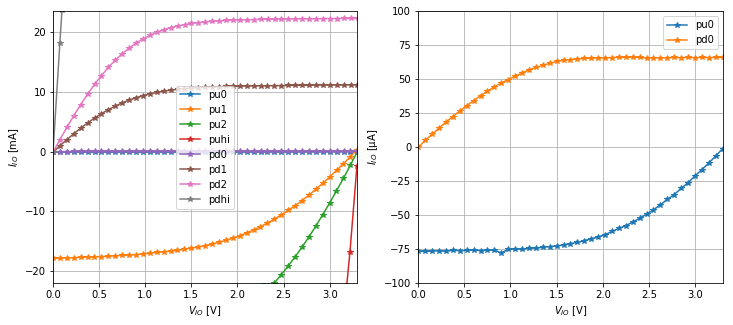

In [226]:
def _block():
    measdata = data["iodrive"]
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    names = ("pu0", "pu1", "pu2", "puhi", "pd0", "pd1", "pd2", "pdhi")
    for name in names:
        _d = measdata[name]
        plt.plot(_d[:, 0], 1e3*_d[:, 1], '*-')
    plt.xlabel("$V_{IO}$ [V]")
    plt.ylabel("$I_{IO}$ [mA]")
    plt.axis((0, 3.3, -22, 23.5))
    plt.grid("on")
    plt.legend(names, loc="center")
    
    plt.subplot(1, 2, 2)
    names = ("pu0", "pd0")
    for name in names:
        _d = measdata[name]
        plt.plot(_d[:, 0], 1e6*_d[:, 1], '*-')
    plt.xlabel("$V_{IO}$ [V]")
    plt.ylabel("$I_{IO}$ [µA]")
    plt.axis((0, 3.3, -100, 100))
    plt.grid("on")
    plt.legend(names)

    plt.show()
_block()    

* pmos has higher drive current than nmos

## IO Input threashold

* conf2
* green: TestIO1
* yellow: TestIO4
* blue: TestIO4.PAD2CORE

In [310]:
def _block():
    green_ch.mode = MeasMode.FVMV
    green_ch.force = 0 # TestIO1 force 0V -> TestIO2 PU0 -> TestIO3 PD2 -> TestIO4 PU0
    
    yellow_ch.mode = MeasMode.FVMV
    yellow_ch.force = 0

    blue_ch.mode = MeasMode.HVMV
    
    vdd18_ch.mode = MeasMode.FVMI
    
    def _setandmeasure(vset):
        meas = []
        yellow_ch.force = vset
        
        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = blue_channel
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = vdd18_channel
        meas.append(board.measure(count=100)[0])
        
        return meas

    vs = np.concatenate((
        np.arange(0, 0.75, 0.15),
        np.arange(0.75, 1.05, 0.01),
        np.arange(1.05, 3.301, 0.15),
    ))

    data["iothreshold"] = np.array(tuple(_setandmeasure(v) for v in np.concatenate((vs, vs[-1:0:-1]))))
    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()        

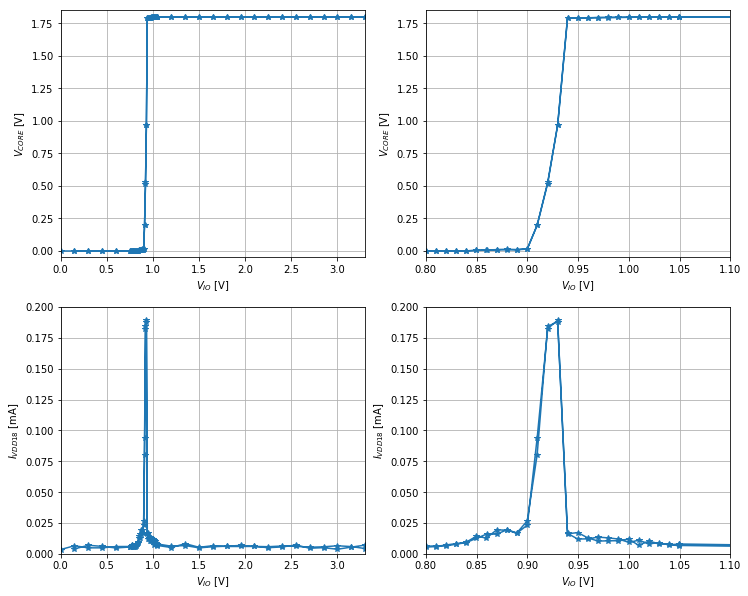

In [312]:
def _block():
    _d = data["iothreshold"]
    plt.figure(figsize=(12,10))

    plt.subplot(2, 2, 1)
    plt.plot(_d[:, 0], _d[:, 2], '*-')
    plt.axis([0, 3.3, -0.05, 1.85])
    plt.xlabel("$V_{IO}$ [V]")
    plt.ylabel("$V_{CORE}$ [V]")
    plt.grid("on")

    plt.subplot(2, 2, 2)
    plt.plot(_d[:, 0], _d[:, 2], '*-')
    plt.axis([0.8, 1.1, -0.05, 1.85])
    plt.xlabel("$V_{IO}$ [V]")
    plt.ylabel("$V_{CORE}$ [V]")
    plt.grid("on")

    plt.subplot(2, 2, 3)
    plt.plot(_d[:, 0], 1e3*_d[:, 3], '*-')
    plt.axis([0, 3.3, 0, 0.2])
    plt.xlabel("$V_{IO}$ [V]")
    plt.ylabel("$I_{VDD18}$ [mA]")
    plt.grid("on")

    plt.subplot(2, 2, 4)
    plt.plot(_d[:, 0], 1e3*_d[:, 3], '*-')
    plt.axis([0.8, 1.1, 0, 0.2])
    plt.xlabel("$V_{IO}$ [V]")
    plt.ylabel("$I_{VDD18}$ [mA]")
    plt.grid("on")

    plt.show()
_block()

* input threshold around 0.925V
* no hysteresis on input

## SR latches
### Connection

* Green: S_Sn (pin 49)
* Yellow: R_Rn (pin 48)
* Blue: latch output (pin 30-37)

### S_Sn low; R_Rn high
In next measurement we set the S_Sn pin to low and R_Rn to high and measure pin 30-37 with multimeter.  
This should reset a srlatch and set a nsnrlatch.

In [384]:
green_ch.mode = MeasMode.HVMV
green_ch.force = 0.0
green_ch.mode = MeasMode.FVMV
yellow_ch.mode = MeasMode.HVMV
yellow_ch.force = 1.8
yellow_ch.mode = MeasMode.FVMV    

| Pin | cell         | conn   | $V_{meas}$ |
|-----|--------------|--------|------------|
| 37  | srlatch_x1   | direct | 0.00V      |
| 36  | srlatch_x1   | GPIO   | 3.30V      |
| 35  | srlatch_x4   | direct | 0.00V      |
| 34  | srlatch_x4   | GPIO   | 3.30V      |
| 33  | nsnrlatch_x1 | direct | 1.79V      |
| 32  | nsnrlatch_x1 | GPIO   | 0.00V      |
| 31  | nsnrlatch_x4 | direct | 1.79V      |
| 30  | nsnrlatch_x4 | GPIO   | 0.00V      |

### S_Sn high; R_Rn low
In next measurement we set the S_Sn pin to high and R_Rn to low and measure pin 30-37 with multimeter.  
This should set a srlatch and reset a nsnrlatch.

In [385]:
green_ch.mode = MeasMode.HVMV
green_ch.force = 1.8
green_ch.mode = MeasMode.FVMV
yellow_ch.mode = MeasMode.HVMV
yellow_ch.force = 0
yellow_ch.mode = MeasMode.FVMV    

| Pin | cell         | conn   | $V_{meas}$ |
|-----|--------------|--------|------------|
| 37  | srlatch_x1   | direct | 1.79V      |
| 36  | srlatch_x1   | GPIO   | 0.00V      |
| 35  | srlatch_x4   | direct | 1.79V      |
| 34  | srlatch_x4   | GPIO   | 0.00V      |
| 33  | nsnrlatch_x1 | direct | 0.00V      |
| 32  | nsnrlatch_x1 | GPIO   | 3.30V      |
| 31  | nsnrlatch_x4 | direct | 0.00V      |
| 30  | nsnrlatch_x4 | GPIO   | 3.30V      |


## Drive strength

Put latch in set or reset state and measure current as a function of forced voltage on the output.
This measurement has to be done by connecting the blue channel to each of the outputs and performing the measurements.

In [167]:
def _block(*, latch):
    measdata = data.get("latchdrive", {})
    board.measchannel = blue_channel

    green_ch.mode = MeasMode.FVMV
    yellow_ch.mode = MeasMode.FVMV
    blue_ch.currentrange = "2mA"
    
    def _setandmeasure(vset):
        meas = []

        # S_Sn low; R_Rn high
        green_ch.force = 0
        yellow_ch.force = 1.8
        
        blue_ch.mode = MeasMode.FVMV
        blue_ch.force = vset
        sleep(0.1)
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # S_Sn low; R_Rn high
        green_ch.force = 1.8
        yellow_ch.force = 0
        
        sleep(0.1)
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.concatenate((
        np.arange(0, 0.8, 0.025),
        np.arange(0.7, 1.0, 0.0025),
        np.arange(1.0, 1.801, 0.025),
    ))
    measdata[latch] = np.array(tuple(_setandmeasure(v) for v in vs))

    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV

    data["latchdrive"] = measdata
    
    blue_ch.mode = MeasMode.HVMV
# Connect the right pin and measure with right name
# _block(latch="srlatch_x1") # Pin 37
# _block(latch="srlatch_x4") # Pin 35
# _block(latch="nsnrlatch_x1") # Pin 33
# _block(latch="nsnrlatch_x4") # Pin 31

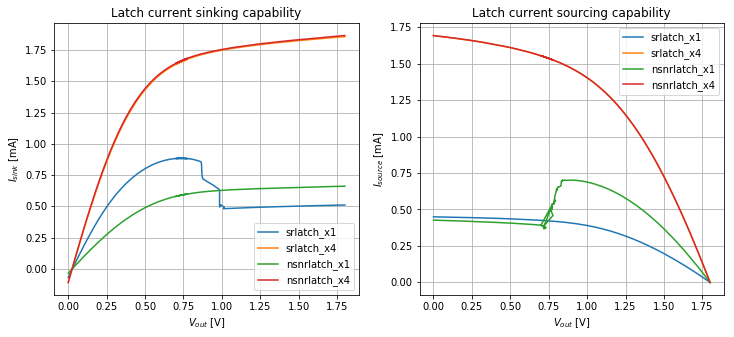

In [386]:
def _block():
    measdata = data["latchdrive"]
    plt.figure(figsize=(12,5))

    # Source current
    plt.subplot(1, 2, 1)
    _d = measdata["srlatch_x1"]
    plt.plot(_d[:, 0], 1e3*_d[:, 1])
    _d = measdata["srlatch_x4"]
    plt.plot(_d[:, 0], 1e3*_d[:, 1])
    _d = measdata["nsnrlatch_x1"]
    plt.plot(_d[:, 2], 1e3*_d[:, 3])
    _d = measdata["nsnrlatch_x4"]
    plt.plot(_d[:, 2], 1e3*_d[:, 3])

    plt.title("Latch current sinking capability")
    plt.xlabel("$V_{out}$ [V]")
    plt.ylabel("$I_{sink}$ [mA]")
    plt.legend(("srlatch_x1", "srlatch_x4", "nsnrlatch_x1", "nsnrlatch_x4"))
    plt.grid("on")

    # Sink current
    plt.subplot(1, 2, 2)
    _d = measdata["srlatch_x1"]
    plt.plot(_d[:, 2], -1e3*_d[:, 3])
    _d = measdata["srlatch_x4"]
    plt.plot(_d[:, 2], -1e3*_d[:, 3])
    _d = measdata["nsnrlatch_x1"]
    plt.plot(_d[:, 0], -1e3*_d[:, 1])
    _d = measdata["nsnrlatch_x4"]
    plt.plot(_d[:, 0], -1e3*_d[:, 1])

    plt.title("Latch current sourcing capability")
    plt.xlabel("$V_{out}$ [V]")
    plt.ylabel("$I_{source}$ [mA]")
    plt.legend(("srlatch_x1", "srlatch_x4", "nsnrlatch_x1", "nsnrlatch_x4"))
    plt.grid("on")

    plt.show()
_block()

# SRAM cell
## SNM

config:

* green: "SRAM1 INT", pin 7
* yellow: "SRAM1 INTn", pin 10
* blue: "SRAM1/2 WL", pin 11
* vdd18: "SRAM1 BL", pin 8; "SRAM1 BLn", pin 9

### $SNM_{hold}$

This is with word line closed (e.g. 0V)

In [424]:
def _block():
    # Close WL
    blue_ch.mode = MeasMode.HVMV
    blue_ch.force = 0
    blue_ch.mode = MeasMode.FVMV

    vs = np.arange(0, 1.801, 0.025)

    measdata = data.get("sram", {})
    measdata["snmhold"] = snmhold = {}
    data["sram"] = measdata

    # Force int, measure intn
    green_ch.mode = MeasMode.FVMV
    green_ch.force = 0.0
    
    yellow_ch.mode = MeasMode.HIMV
    
    def _setandmeasure(vset):
        meas = []
        green_ch.force = vset
        
        board.measchannel = green_channel
        green_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])
        
        return meas
    
    snmhold["forceint"] = np.array(tuple(_setandmeasure(v) for v in vs))

    # Force intn, measure intn
    green_ch.mode = MeasMode.HIMV

    yellow_ch.mode = MeasMode.FVMV
    yellow_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        yellow_ch.force = vset
        
        board.measchannel = green_channel
        green_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        return meas

    snmhold["forceintn"] = np.array(tuple(_setandmeasure(v) for v in vs))

    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV    
_block()

### Plot results

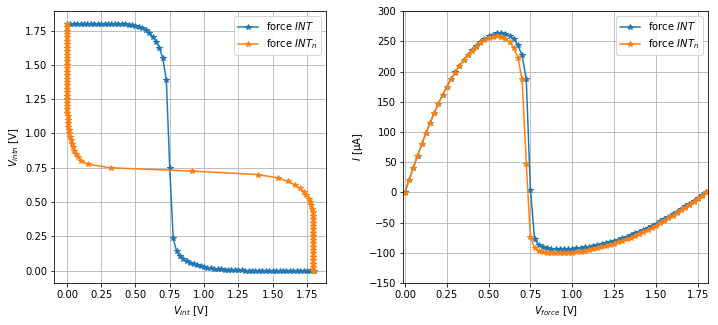

In [425]:
def _block():
    snmhold = data["sram"]["snmhold"]
    _d1 = snmhold["forceint"]
    _d2 = snmhold["forceintn"]
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(_d1[:, 0], _d1[:, 2], '*-')
    plt.plot(_d2[:, 0], _d2[:, 2], '*-')
    plt.xlabel("$V_{int}$ [V]")
    plt.ylabel("$V_{intn}$ [V]")
    plt.legend(("force $INT$", "force $INT_n$"))
    plt.axis((-0.01, 1.81, -0.01, 1.81))
    plt.axis("square")
    plt.grid("on")

    plt.subplot(1, 2, 2)
    plt.plot(_d1[:, 0], 1e6*_d1[:, 1], '*-')
    plt.plot(_d2[:, 2], 1e6*_d2[:, 3], '*-')
    plt.xlabel("$V_{force}$ [V]")
    plt.ylabel("$I$ [µA]")
    plt.legend(("force $INT$", "force $INT_n$"))
    plt.axis((-0.01, 1.81, -150, 300))
    plt.grid("on")

    plt.show()
_block()

* $SNM_{hold}$ of around 600mV

### $SNM_{read}$

This is with word line open (e.g. 1.8V)

In [426]:
def _block():
    # Open WL
    blue_ch.mode = MeasMode.HVMV
    blue_ch.force = 0
    blue_ch.mode = MeasMode.FVMV

    vs = np.arange(0, 1.801, 0.025)

    measdata = data.get("sram", {})
    measdata["snmread"] = snmhold = {}
    data["sram"] = measdata

    # Force int, measure intn
    green_ch.mode = MeasMode.FVMV
    green_ch.force = 0.0
    
    yellow_ch.mode = MeasMode.HIMV
    
    def _setandmeasure(vset):
        meas = []
        green_ch.force = vset
        
        board.measchannel = green_channel
        green_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])
        
        return meas
    
    snmhold["forceint"] = np.array(tuple(_setandmeasure(v) for v in vs))

    # Force intn, measure intn
    green_ch.mode = MeasMode.HIMV

    yellow_ch.mode = MeasMode.FVMV
    yellow_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        yellow_ch.force = vset
        
        board.measchannel = green_channel
        green_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        return meas

    snmhold["forceintn"] = np.array(tuple(_setandmeasure(v) for v in vs))

    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV    
    # Close WL again
    blue_ch.force = 0
_block()

In [427]:
def _block():
    snmhold = data["sram"]["snmread"]
    _d1 = snmhold["forceint"]
    _d2 = snmhold["forceintn"]
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(_d1[:, 0], _d1[:, 2], '*-')
    plt.plot(_d2[:, 0], _d2[:, 2], '*-')
    plt.xlabel("$V_{int}$ [V]")
    plt.ylabel("$V_{intn}$ [V]")
    plt.legend(("force $INT$", "force $INT_n$"))
    plt.axis((-0.01, 1.81, -0.01, 1.81))
    plt.axis("square")
    plt.grid("on")

    plt.subplot(1, 2, 2)
    plt.plot(_d1[:, 0], 1e6*_d1[:, 1], '*-')
    plt.plot(_d2[:, 2], 1e6*_d2[:, 3], '*-')
    plt.xlabel("$V_{force}$ [V]")
    plt.ylabel("$I$ [µA]")
    plt.legend(("force $INT$", "force $INT_n$"))
    plt.axis((-0.01, 1.81, -150, 300))
    plt.grid("on")

    plt.show()
_block()

* Data is the same as for $SNM_{hold}$ which should not be the case. After checking the design it was seen that wrong word line is connected so the SRAM measured has always the word line closed.

## $I_{read}$ & WTP

### Cell 1
config:
* green: "SRAM1 BL", pin 8
* yellow: "SRAM1 BLn", pin 9
* blue: "SRAM1/2 WL", pin 11

In [480]:
def _block():
    sramdata = data.get("sram", {})
    wtpdata = sramdata.get("wtp", {})
    wtpdata["cell1"] = cell1data = {}
    sramdata["wtp"] = wtpdata
    data["sram"] = sramdata
    
    # Set cell to one value
    blue_ch.mode = MeasMode.FVMV
    blue_ch.force = 1.8 # WL open
    green_ch.mode = MeasMode.FVMV
    green_ch.currentrange = "200µA"
    green_ch.force = 1.8 # BL -> 1
    yellow_ch.mode = MeasMode.FVMV
    yellow_ch.currentrange = "200µA"
    yellow_ch.force = 0.0 # BLn -> 0
    yellow_ch.force = 1.8 # BLn -> 1
    
    vs = np.arange(0, 1.801, 0.025)
    vs = np.concatenate((vs[-1:1:-1], vs))

    def _setandmeasure(ch, vset):
        meas = []
        ch.force = vset
        
        board.measchannel = green_channel
        green_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        return meas

    # WTP lowering BL
    cell1data["blsweep"] = np.array(tuple(_setandmeasure(green_ch, v) for v in vs))
    
    # WTP lowering BLn
    cell1data["blnsweep"] = np.array(tuple(_setandmeasure(yellow_ch, v) for v in vs))
    
    blue_ch.force = 0
    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV
_block()

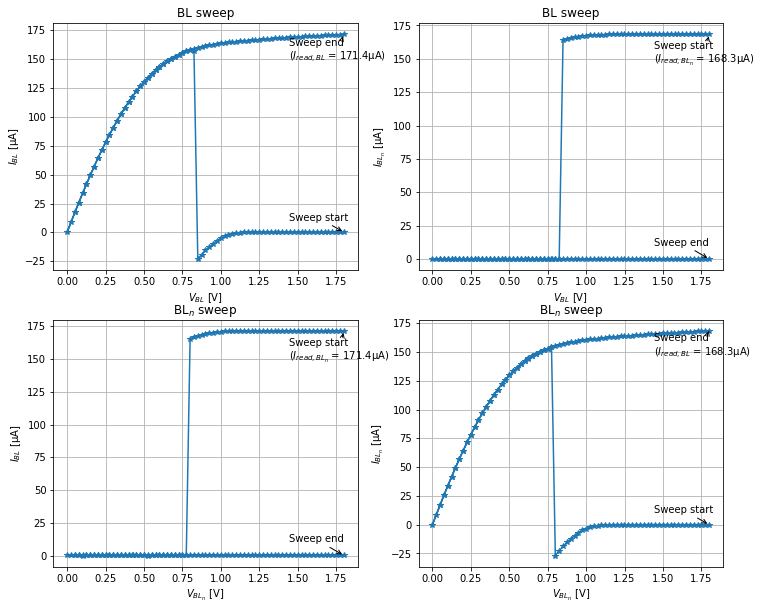

In [481]:
def _block():
    _cd = data["sram"]["wtp"]["cell1"] 
    _d = _cd["blsweep"]
    _d2 = _cd["blnsweep"]

    plt.figure(figsize=(12,10))

    points = _d.shape[0]
    annargs = {"arrowprops": {"arrowstyle": "->"}}

    plt.subplot(2, 2, 1)
    plt.plot(_d[:, 0], 1e6*_d[:, 1], '*-')
    plt.title("BL sweep")
    x = _d[0, 0]
    y = 1e6*_d[0, 1]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start", **annargs)
    x = _d[-1, 0]
    y = 1e6*_d[-1, 1]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end\n($I_{{read,BL}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    plt.xlabel("$V_{BL}$ [V]")
    plt.ylabel("$I_{BL}$ [µA]")
    plt.grid("on")

    plt.subplot(2, 2, 2)
    plt.plot(_d[:, 0], 1e6*_d[:, 3], '*-')
    plt.title("BL sweep")
    x = _d[0, 0]
    y = 1e6*_d[0, 3]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start\n($I_{{read,BL_n}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    x = _d[-1, 0]
    y = 1e6*_d[-1, 3]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end", **annargs)
    plt.xlabel("$V_{BL}$ [V]")
    plt.ylabel("$I_{BL_n}$ [µA]")
    plt.grid("on")

    plt.subplot(2, 2, 3)
    plt.plot(_d2[:, 2], 1e6*_d2[:, 1], '*-')
    plt.title("BL$_n$ sweep")
    x = _d2[0, 2]
    y = 1e6*_d2[0, 1]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start\n($I_{{read,BL_n}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    x = _d2[-1, 2]
    y = 1e6*_d2[-1, 1]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end", **annargs)
    plt.xlabel("$V_{BL_n}$ [V]")
    plt.ylabel("$I_{BL}$ [µA]")
    plt.grid("on")

    plt.subplot(2, 2, 4)
    plt.plot(_d2[:, 2], 1e6*_d2[:, 3], '*-')
    plt.title("BL$_n$ sweep")
    x = _d2[0, 2]
    y = 1e6*_d2[0, 3]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start", **annargs)
    x = _d2[-1, 2]
    y = 1e6*_d2[-1, 3]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end\n($I_{{read,BL}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    plt.xlabel("$V_{BL_n}$ [V]")
    plt.ylabel("$I_{BL_n}$ [µA]")
    plt.grid("on")

    plt.show()
_block()

### Cell 2
config:
* green: "SRAM2 BL", pin 12
* yellow: "SRAM2 BLn", pin 13
* blue: "SRAM1/2 WL", pin 11

In [483]:
def _block():
    sramdata = data.get("sram", {})
    wtpdata = sramdata.get("wtp", {})
    wtpdata["cell2"] = cell2data = {}
    sramdata["wtp"] = wtpdata
    data["sram"] = sramdata
    
    # Set cell to one value
    blue_ch.mode = MeasMode.FVMV
    blue_ch.force = 1.8 # WL open
    green_ch.mode = MeasMode.FVMV
    green_ch.currentrange = "200µA"
    green_ch.force = 1.8 # BL -> 1
    yellow_ch.mode = MeasMode.FVMV
    yellow_ch.currentrange = "200µA"
    yellow_ch.force = 0.0 # BLn -> 0
    yellow_ch.force = 1.8 # BLn -> 1
    
    vs = np.arange(0, 1.801, 0.025)
    vs = np.concatenate((vs[-1:1:-1], vs))

    def _setandmeasure(ch, vset):
        meas = []
        ch.force = vset
        
        board.measchannel = green_channel
        green_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        green_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        board.measchannel = yellow_channel
        yellow_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        yellow_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        return meas

    # WTP lowering BL
    cell2data["blsweep"] = np.array(tuple(_setandmeasure(green_ch, v) for v in vs))
    
    # WTP lowering BLn
    cell2data["blnsweep"] = np.array(tuple(_setandmeasure(yellow_ch, v) for v in vs))
    
    blue_ch.force = 0
    green_ch.mode = MeasMode.HVMV
    yellow_ch.mode = MeasMode.HVMV
_block()

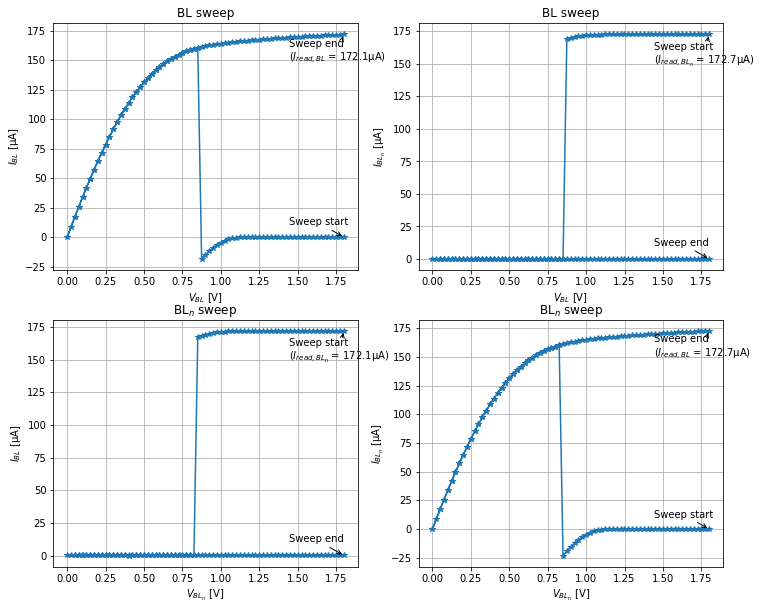

In [484]:
def _block():
    _cd = data["sram"]["wtp"]["cell2"] 
    _d = _cd["blsweep"]
    _d2 = _cd["blnsweep"]

    plt.figure(figsize=(12,10))

    points = _d.shape[0]
    annargs = {"arrowprops": {"arrowstyle": "->"}}

    plt.subplot(2, 2, 1)
    plt.plot(_d[:, 0], 1e6*_d[:, 1], '*-')
    plt.title("BL sweep")
    x = _d[0, 0]
    y = 1e6*_d[0, 1]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start", **annargs)
    x = _d[-1, 0]
    y = 1e6*_d[-1, 1]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end\n($I_{{read,BL}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    plt.xlabel("$V_{BL}$ [V]")
    plt.ylabel("$I_{BL}$ [µA]")
    plt.grid("on")

    plt.subplot(2, 2, 2)
    plt.plot(_d[:, 0], 1e6*_d[:, 3], '*-')
    plt.title("BL sweep")
    x = _d[0, 0]
    y = 1e6*_d[0, 3]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start\n($I_{{read,BL_n}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    x = _d[-1, 0]
    y = 1e6*_d[-1, 3]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end", **annargs)
    plt.xlabel("$V_{BL}$ [V]")
    plt.ylabel("$I_{BL_n}$ [µA]")
    plt.grid("on")

    plt.subplot(2, 2, 3)
    plt.plot(_d2[:, 2], 1e6*_d2[:, 1], '*-')
    plt.title("BL$_n$ sweep")
    x = _d2[0, 2]
    y = 1e6*_d2[0, 1]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start\n($I_{{read,BL_n}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    x = _d2[-1, 2]
    y = 1e6*_d2[-1, 1]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end", **annargs)
    plt.xlabel("$V_{BL_n}$ [V]")
    plt.ylabel("$I_{BL}$ [µA]")
    plt.grid("on")

    plt.subplot(2, 2, 4)
    plt.plot(_d2[:, 2], 1e6*_d2[:, 3], '*-')
    plt.title("BL$_n$ sweep")
    x = _d2[0, 2]
    y = 1e6*_d2[0, 3]
    plt.annotate(xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep start", **annargs)
    x = _d2[-1, 2]
    y = 1e6*_d2[-1, 3]
    plt.annotate(
        xy=(x, y), xytext=(0.8*x, 0.8*y + 10), s="Sweep end\n($I_{{read,BL}}$ = {:.1f}µA)".format(y),
        **annargs,
    )
    plt.xlabel("$V_{BL_n}$ [V]")
    plt.ylabel("$I_{BL_n}$ [µA]")
    plt.grid("on")

    plt.show()
_block()

# Deprecated Board Bring-up

This section gives old results for board bring-up where all inputs are left floating. These results have been superseeded by the configuration conf2 as described in the IO Test chapter.
It is kept in this document as reference and history on evolution one can see during testing.

## Supply ramp-up

For this we connect VDD33 to blue channel and VDD18 to vdd18 channel.

### VDD18 ramp

#### VDD33 = 0V

Blue channel is used to put VDD33 to 0V

In [7]:
def _block():
    measdata = data.get("bringup_depr", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.FVMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=0V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = 0A

Blue channel is put to zero current

In [8]:
def _block():
    measdata = data.get("bringup_depr", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.FIMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FIMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FIMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=0A)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = HighV

Blue channel is put in High-V mode

In [9]:
def _block():
    measdata = data.get("bringup_depr", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.HVMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.HVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.HVMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=High-V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = HighI

Blue channel is put in High-I mode

In [10]:
def _block():
    measdata = data.get("bringup_depr", {})

    blue_ch.mode = MeasMode.HVMI
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.HIMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=High-I)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD33 = Rasp33

The 3.3V is coming directly from the Raspberry Pi; blue channel used only to measure the voltage on VDD33.

In [21]:
def _block():
    measdata = data.get("bringup_depr", {})

    blue_ch.mode = MeasMode.HVMV
    blue_ch.force = 0.0
    blue_ch.currentrange = "extres"
    vdd18_ch.mode = MeasMode.HVMV
    vdd18_ch.force = 0.0
    vdd18_ch.currentrange = "extres"

    def _setandmeasure(vset):
        meas = []
        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        vdd18_ch.force = vset
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])
        
        # Measure current on VDD33
        board.measchannel = blue_channel
        meas.append(board.measure(count=100)[0])
        meas.append(np.nan) # No current measurement

        return meas
    
    vs = np.arange(0, 1.801, 0.05)
    measdata["VDD18 (VDD33=Rasp33)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata

    vdd18_ch.force = 0.0
    blue_ch.force = 0.0
    blue_ch.mode = MeasMode.HVMV
_block()

#### Plot results

In [376]:
def _block():
    d_0V = data["bringup_depr"]["VDD18 (VDD33=0V)"]
    d_0A = data["bringup_depr"]["VDD18 (VDD33=0A)"]
    d_HiV = data["bringup_depr"]["VDD18 (VDD33=High-V)"]
    d_HiA = data["bringup_depr"]["VDD18 (VDD33=High-I)"]
    d_r33 = data["bringup_depr"]["VDD18 (VDD33=Rasp33)"]
    ds = (d_0V, d_0A, d_HiV, d_HiA, d_r33)
    lgnd = ("VDD33=0V", "VDD33=0A", "VDD33=High-V", "VDD33=High-I", "VDD33=Raspberry 3.3V")
    
    plt.figure(figsize=(12,10))

    plt.subplot(2, 2, 1)
    for d in ds:
        plt.plot(d[:, 0], 1e3*d[: , 1], '*-')
    plt.legend(lgnd, loc="center right")
    plt.xlabel("$V_{VDD18}$ [V]")
    plt.ylabel("$I_{VDD18}$ [mA]")
    plt.grid("on")

    plt.subplot(2, 2, 2)
    for d in ds:
        plt.plot(d[:, 0], d[: , 2], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD18}$ [V]")
    plt.ylabel("$V_{VDD33}$ [V]")
    plt.grid("on")

    plt.subplot(2, 2, 3)
    for d in ds:
        plt.plot(d[:, 0], 1e3*d[: , 3], '*-')
    plt.legend(lgnd[:-1])
    plt.xlabel("$V_{VDD18}$ [V]")
    plt.ylabel("$I_{VDD33}$ [mA]")
    plt.grid("on")

    plt.show()
_block()

* When VDD33 is kept at 0V current start to flow into it from VDD18 when VDD18 reaches 1.8V
* When VDD33 is @ 3.3V (almost) no current is flowing into VDD18 when ramping it or @ 1.8V.

### VDD33 ramp

#### VDD18=0V
* Keep VDD18 to 0V as it otherwise will clamp on maximum current
* Connect blue channel to VDD33

In [68]:
def _block():
    measdata = data.get("bringup_depr", {})
    
    vdd18_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 0
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=0V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD18=1.8V
* Set voltage on VDD18 to 1.8V, will measure clamped voltage
* Connect blue channel to VDD33

In [70]:
def _block():
    measdata = data.get("bringup_depr", {})
    
    vdd18_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 1.8
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=1.8V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD18=High-V
* Set VDD18 to High-V
* Connect blue channel to VDD33

In [74]:
def _block():
    measdata = data.get("bringup_depr", {})
    
    vdd18_ch.mode = MeasMode.HVMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 0
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.HVMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.HVMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=High-V)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### VDD18=High-I
* Set VDD18 to High-I
* Connect blue channel to VDD33

In [76]:
def _block():
    measdata = data.get("bringup_depr", {})
    
    vdd18_ch.mode = MeasMode.HIMV
    vdd18_ch.currentrange = "extres"
    vdd18_ch.force = 0
    
    blue_ch.mode = MeasMode.FVMV
    vdd18_ch.currentrange = "extres"
    blue_ch.force = 0

    def _setandmeasure(vset):
        meas = []
        blue_ch.force = vset

        board.measchannel = vdd18_channel
        vdd18_ch.mode = MeasMode.HIMV
        meas.append(board.measure(count=100)[0])
        vdd18_ch.mode = MeasMode.HIMI
        meas.append(board.measure(count=100)[0])

        board.measchannel = blue_channel
        blue_ch.mode = MeasMode.FVMV
        meas.append(board.measure(count=100)[0])
        blue_ch.mode = MeasMode.FVMI
        meas.append(board.measure(count=100)[0])

        return meas

    vs = np.arange(0, 3.301, 0.025)
    measdata["VDD33 (VDD18=High-I)"] = np.array(tuple(_setandmeasure(v) for v in vs))
    
    data["bringup_depr"] = measdata
    
    vdd18_ch.mode = MeasMode.HVMV
    blue_ch.mode = MeasMode.HVMV
_block()

#### Plot results

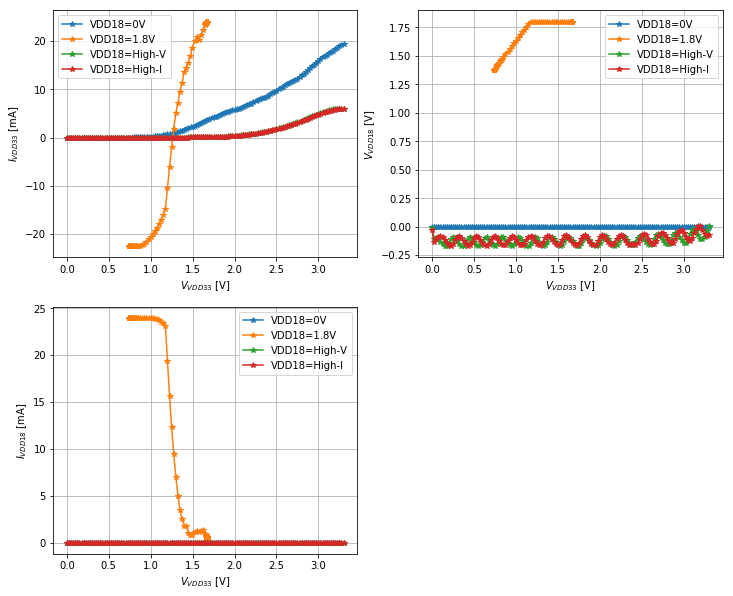

In [375]:
def _block():
    d_0V = data["bringup_depr"]["VDD33 (VDD18=0V)"]
    d_1V8 = data["bringup_depr"]["VDD33 (VDD18=1.8V)"]
    d_HiV = data["bringup_depr"]["VDD33 (VDD18=High-V)"]
    d_HiA = data["bringup_depr"]["VDD33 (VDD18=High-I)"]
    ds = (d_0V, d_1V8, d_HiV, d_HiA)
    lgnd = ("VDD18=0V", "VDD18=1.8V", "VDD18=High-V", "VDD18=High-I")
    
    plt.figure(figsize=(12,10))

    plt.subplot(2, 2, 1)
    for d in ds:
        plt.plot(d[:, 2], 1e3*d[: , 3], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD33}$ [V]")
    plt.ylabel("$I_{VDD33}$ [mA]")
    plt.grid("on")

    plt.subplot(2, 2, 2)
    for d in ds:
        plt.plot(d[:, 2], d[: , 0], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD33}$ [V]")
    plt.ylabel("$V_{VDD18}$ [V]")
    plt.grid("on")

    plt.subplot(2, 2, 3)
    for d in ds:
        plt.plot(d[:, 2], 1e3*d[: , 1], '*-')
    plt.legend(lgnd)
    plt.xlabel("$V_{VDD33}$ [V]")
    plt.ylabel("$I_{VDD18}$ [mA]")
    plt.grid("on")

    plt.show()
_block()

* If VDD18 = 0 current on VDD33 is smaller than when VDD18 = 1.8V
* The SMU can't provide the needed current for 3.3V when VDD18 = 1.8V

## Deprecated static power consumption

* 1.8V provided by SMU, 3.3V provided by.
* Current on VDD33 measured by multimeter (over 1.1 Ohm resistor)
* Voltage on VDD33 measured by connecting it also to blue channel

In [82]:
def _block():
    board.measchannel = vdd18_channel
    vdd18_ch.mode = MeasMode.FVMV
    vdd18_ch.force = 1.8
    v18 = board.measure(count=100)
    vdd18_ch.mode = MeasMode.FVMI
    i18 = board.measure(count=5000)
    
    board.measchannel = blue_channel
    blue_ch.mode = MeasMode.HVMV
    v33 = board.measure(count=100)
    
    print(v18, i18, v33)
_block()

(1.8015, 'V') (-2e-07, 'I') (3.1245, 'V')


|       | Voltage | Current | Power |
|-------|---------|---------|-------|
| VDD18 | 1.802V  | 0.0mA   | 0mW   |
| VDD33 | 3.125V  | 113mA   | 352mW |

* Considerable static power consumption on 3.3V supply

# Playground